<h1><center><font size="6">MIMIC Dataset EDA and Prediction of Hospital LOS</font></center></h1>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#4'>Predict Hospital LOS</a>   
- <a href='#5'>Predict Hospital LOS group</a>   
- <a href='#6'>References</a> 

# <a id='1'>Introduction</a>  

## The original data

**MIMIC**-III (**M**edical **I**nformation **M**art for **I**ntensive **C**are III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. See also references [1], [2].

## This dataset

This dataset contains admission data file from MIMIC dataset. It was added by @drscarlat (see also reference [4]).


# <a id='2'>Prepare the data analysis</a>  

## Load packages

In [1]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report

## Load data

In [2]:
%%time
MIMIC_PATH = "../input/"
mimic_df = pd.read_csv(os.path.join(MIMIC_PATH,'mimic3d.csv'))

CPU times: user 324 ms, sys: 28 ms, total: 352 ms
Wall time: 361 ms


In [3]:
mimic_df.shape

(58976, 28)

In [4]:
mimic_df.head()

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,NumCallouts,NumDiagnosis,NumProcs,AdmitProcedure,NumCPTevents,NumInput,NumLabs,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,WHITE,0.16,2.59,0.00,na,1.30,25.12,43.44,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,WHITE,0.25,2.23,0.99,Endosc control gast hem,1.98,13.61,55.94,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,0.00,0.75,0.17,Non-invasive mech vent,0.83,11.46,33.39,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,WHITE,0.41,0.69,0.27,Part sm bowel resect NEC,0.69,20.30,32.24,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,1
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,WHITE,0.00,3.69,0.82,Aortocor bypas-3 cor art,2.25,20.49,50.61,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,1


# <a id='3'>Data exploration</a>  


In [5]:
def plot_features_distribution(features, title,isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(mimic_df[feature]),kde=True,hist=False, bins=120, label=feature)
        else:
            sns.distplot(mimic_df[feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

In [6]:
def plot_count(feature, title,size=1,df=mimic_df):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

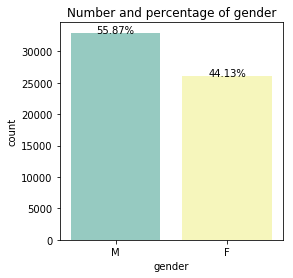

In [7]:
plot_count('gender','gender')

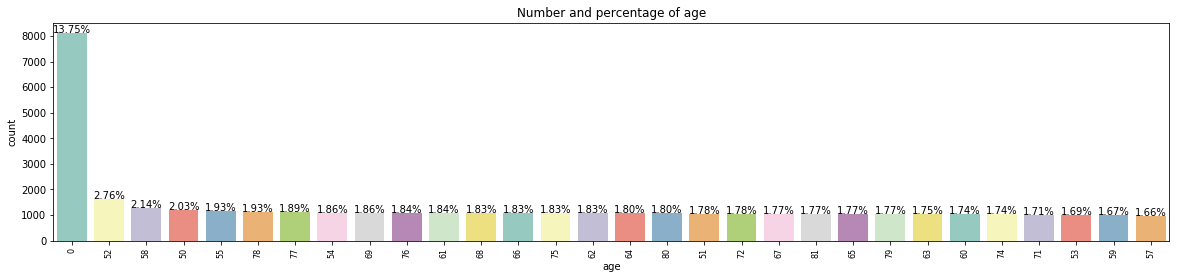

In [8]:
plot_count('age','age',5)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


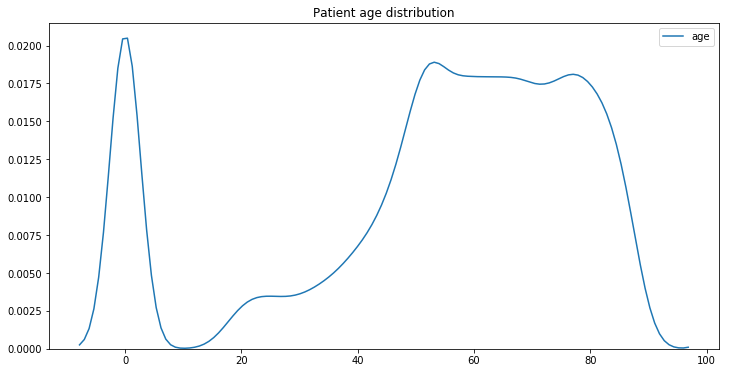

In [9]:
plot_features_distribution(['age'],'Patient age distribution')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


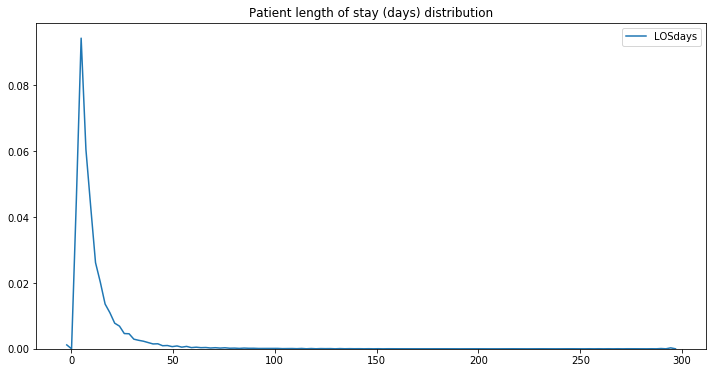

In [10]:
plot_features_distribution(['LOSdays'],'Patient length of stay (days) distribution')

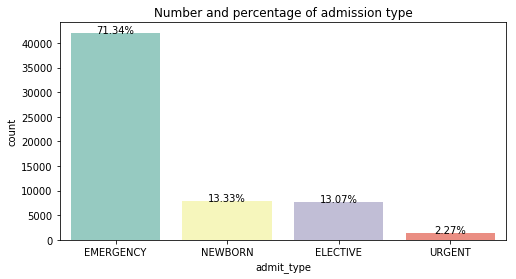

In [11]:
plot_count('admit_type','admission type',2)

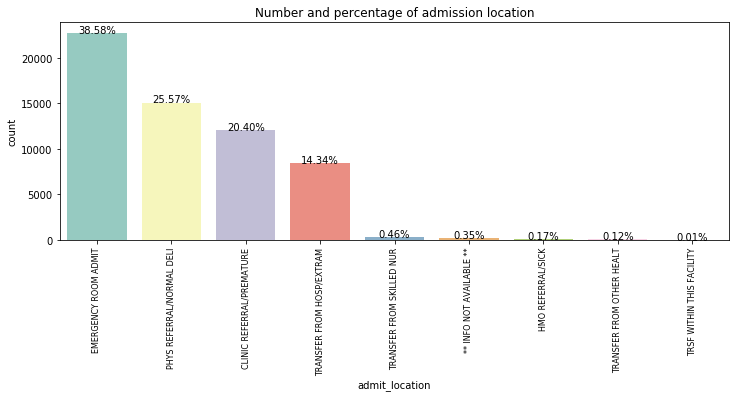

In [12]:
plot_count('admit_location','admission location',3)

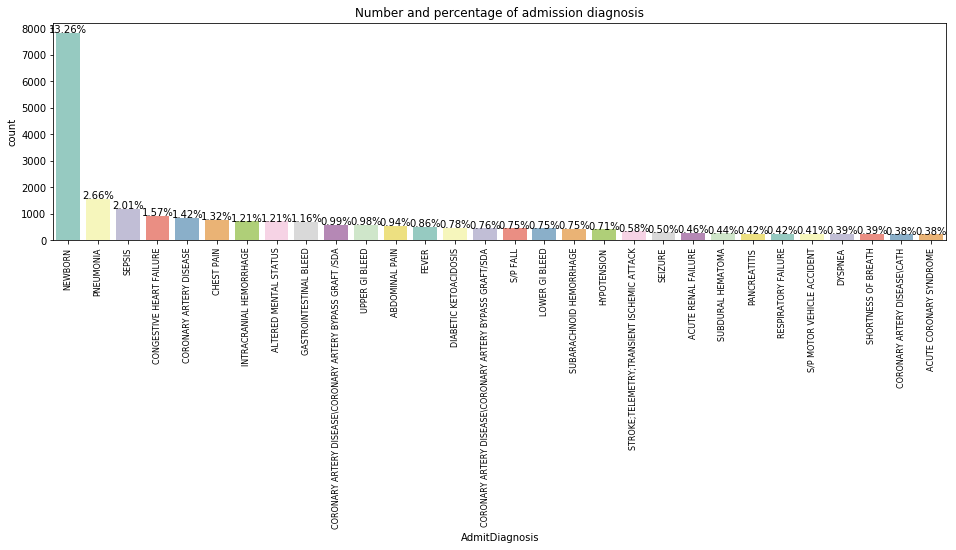

In [13]:
plot_count('AdmitDiagnosis','admission diagnosis',4)

In [14]:
mimic_df.AdmitDiagnosis.nunique()

15691

There is a total of 15691 admission diagnosis. Most of the patients are actually newborn (13.26%). Besides newborn, majority of the admitted patients are diagnosed with pneumonia, sepsis, congestive heart failure, coronary artery disease and chest pain.

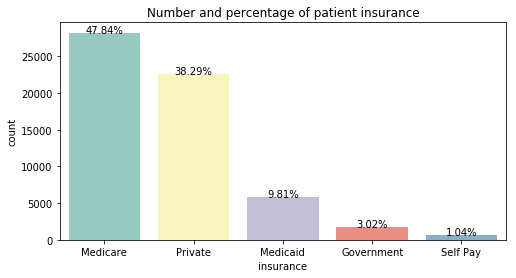

In [15]:
plot_count('insurance','patient insurance',2)

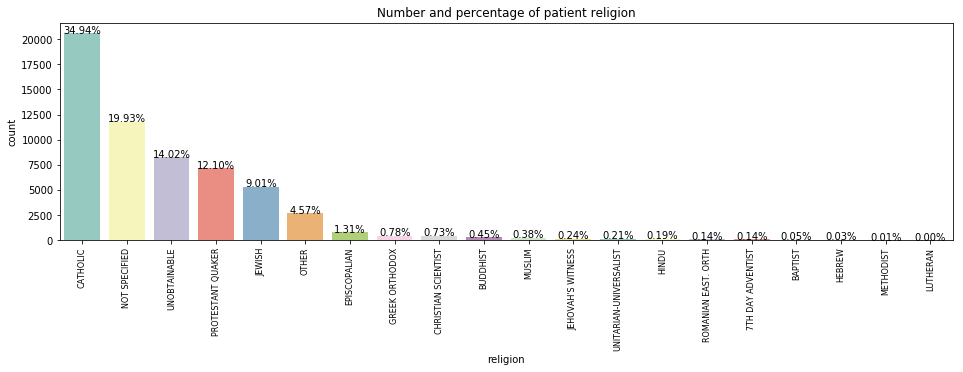

In [16]:
plot_count('religion','patient religion',4)

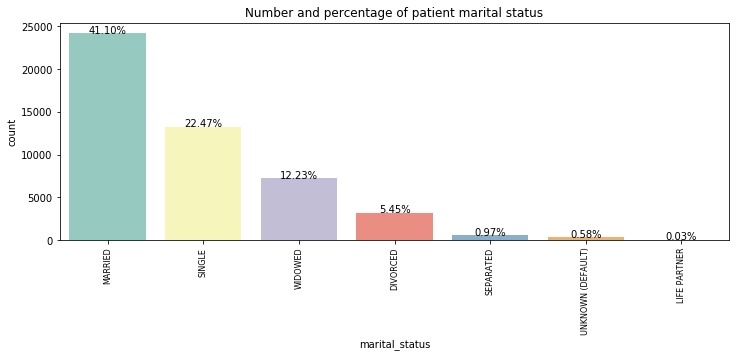

In [17]:
plot_count('marital_status','patient marital status',3)

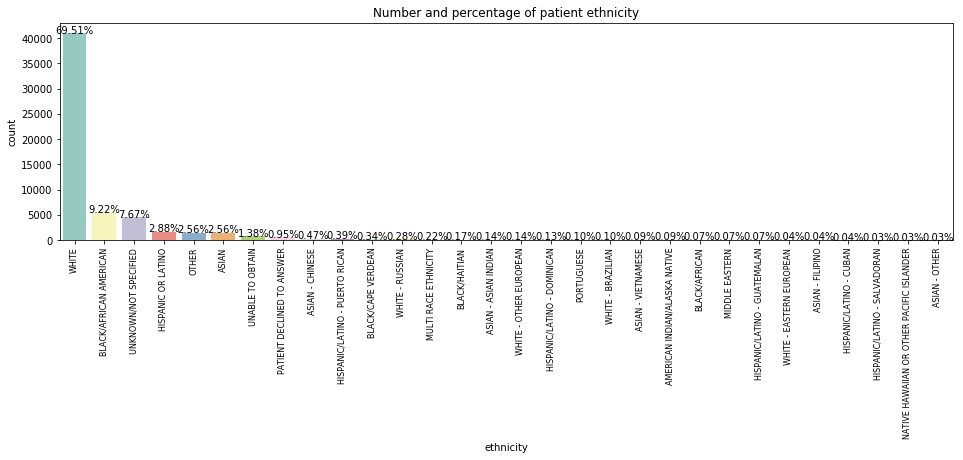

In [18]:
plot_count('ethnicity','patient ethnicity',4)

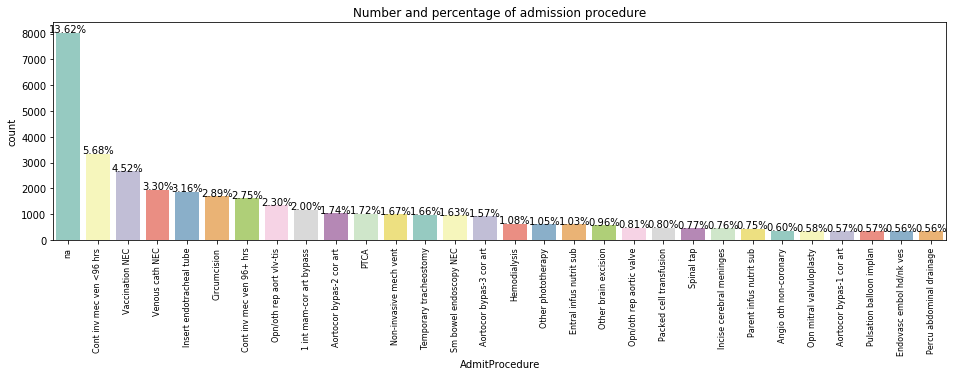

In [19]:
plot_count('AdmitProcedure', 'admission procedure', 4)

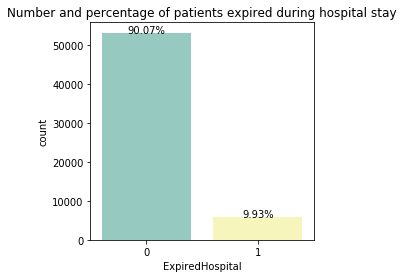

In [20]:
plot_count('ExpiredHospital', 'patients expired during hospital stay')

Let's check most prevalent diagnosis and ages of patients which expired in hospital.  

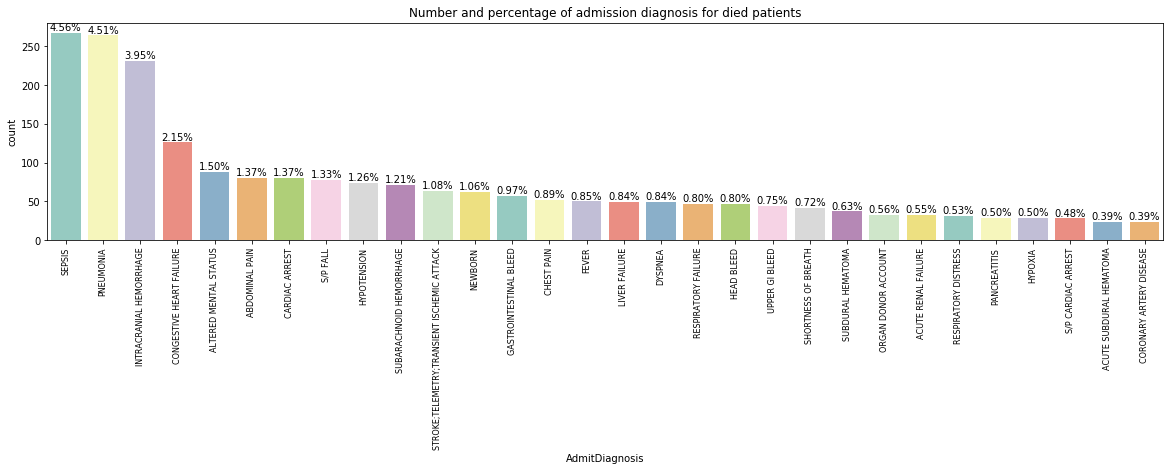

In [21]:
plot_count('AdmitDiagnosis','admission diagnosis for died patients',5,mimic_df[mimic_df.ExpiredHospital==1])

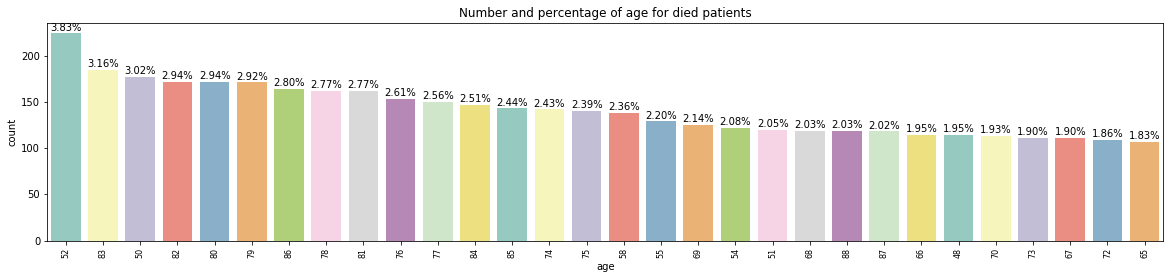

In [22]:
plot_count('age','age for died patients',5,mimic_df[mimic_df.ExpiredHospital==1])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


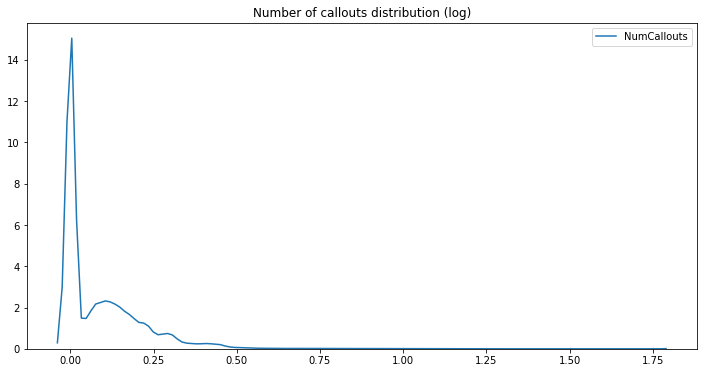

In [23]:
plot_features_distribution(['NumCallouts'], 'Number of callouts distribution (log)',True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


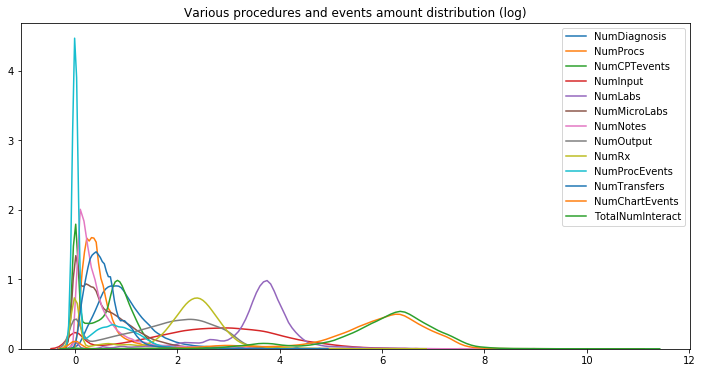

In [24]:
features = ['NumDiagnosis','NumProcs','NumCPTevents','NumInput','NumLabs','NumMicroLabs','NumNotes',
'NumOutput','NumRx','NumProcEvents','NumTransfers','NumChartEvents','TotalNumInteract']
plot_features_distribution(features, 'Various procedures and events amount distribution (log)',True)

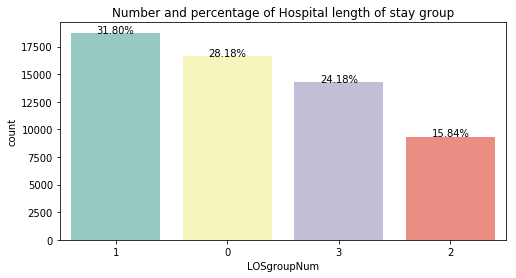

In [25]:
plot_count('LOSgroupNum', 'Hospital length of stay group',2)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


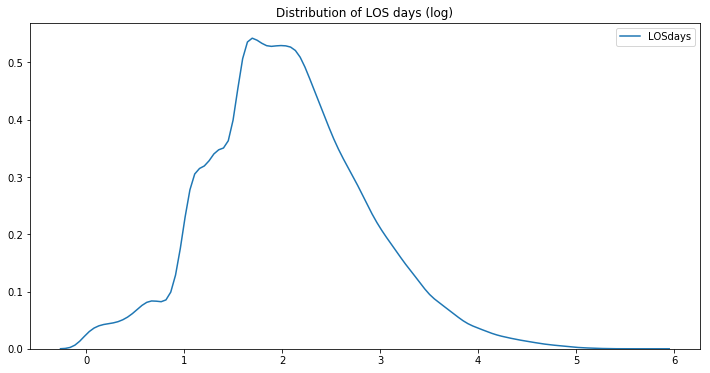

In [26]:
plot_features_distribution(['LOSdays'], 'Distribution of LOS days (log)',True)

# <a id='4'>Predict Hospital LOS</a> 

Accurate prediction of Hospital length of stay is important for the hospital activity management, for optimal forecast of required capacity  for number of beds but also for each procedure specific to a certain group age or diagnosis.  


We encode the categorical features using LabelEncoder.

In [27]:
categorical_features = ['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure']

In [28]:
def encrypt_single_column(data,column):
    le = preprocessing.LabelEncoder()
    le.fit(data.astype(str))
    #le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
    return le.transform(data.astype(str))


def encrypt_columns_collection(data, columns_to_encrypt):
    for column in columns_to_encrypt:
        data[column] = encrypt_single_column(data[column],column)
    return data

In [29]:
mimic_df = encrypt_columns_collection(mimic_df, categorical_features)

Let's split  the dataset in train and test.

In [30]:
train_df, test_df = train_test_split(mimic_df, test_size=0.2, random_state=42, shuffle=True )

We use as predictors only the informations available at the admission time. We are not including information that might be highly correlated with the length of stay (like number of specific events or procedures during the hospital stay). 

In [31]:
predictors = ['gender', 'age', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure']

In [32]:
train_X = train_df[predictors]
test_X = test_df[predictors]
train_y = train_df['LOSdays']
test_y = test_df['LOSdays']

In [33]:
warnings.filterwarnings("ignore")

In [34]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values
params = {'num_leaves': 65, 'min_data_in_leaf': 12, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.81,"bagging_freq": 1, "bagging_fraction": 0.81, "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbose": -1, "nthread": -1,  "random_state": 44000}
oof = np.zeros(len(train_X))
predictions = np.zeros(len(test_X))

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)

    X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    categorical_feature=categorical_features,
                    verbose=500, 
                    early_stopping_rounds=100)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #predictions
    predictions += model.predict(test_X, num_iteration=model.best_iteration_) / folds.n_splits
strLog = "CV score: {}".format(np.sqrt(mean_squared_error(train_y.values, oof)))
print(strLog)

fold 0
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 6.62542	valid_1's l1: 6.61528
[1000]	training's l1: 6.18097	valid_1's l1: 6.23568
[1500]	training's l1: 5.91523	valid_1's l1: 6.0267
[2000]	training's l1: 5.75062	valid_1's l1: 5.90925
[2500]	training's l1: 5.64577	valid_1's l1: 5.84515
[3000]	training's l1: 5.57447	valid_1's l1: 5.81229
[3500]	training's l1: 5.52155	valid_1's l1: 5.7973
[4000]	training's l1: 5.47933	valid_1's l1: 5.79045
[4500]	training's l1: 5.44298	valid_1's l1: 5.7878
Early stopping, best iteration is:
[4649]	training's l1: 5.43322	valid_1's l1: 5.7873
fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 6.59403	valid_1's l1: 6.70307
[1000]	training's l1: 6.15175	valid_1's l1: 6.3138
[1500]	training's l1: 5.88556	valid_1's l1: 6.10927
[2000]	training's l1: 5.72194	valid_1's l1: 6.00041
[2500]	training's l1: 5.61591	valid_1's l1: 5.93913
[3000]	training's l1: 5.54299	valid_1's l1: 5.90725


Let's check now the predictions.

In [35]:
strPred = "Prediction score: {}".format(np.sqrt(mean_squared_error(test_y.values, predictions)))
print(strPred)

Prediction score: 10.103280345470864


In [36]:
results = pd.DataFrame(test_y)
results['predictions'] = predictions
results.head(10)

,LOSdays,predictions
40028,6.79,7.009424
38143,13.50,14.288458
14276,3.38,7.065715
49801,0.25,12.199271
21549,7.08,10.808619
57372,8.08,11.204478
9263,16.04,18.672629
22715,10.17,5.329483
31032,2.75,5.557586
38586,13.83,10.683291


# <a id='4'>Predict Hospital LOS group</a>  

To predict Hospital LOS group, we will use a classifier. There are 4 LOS groups (0,1,2,3).   
We define the target feature as `LOSgroupNum`.

For this model, we add to the predictors list also the number of events and specific procedures.

In [37]:
predictors = ['gender', 'age', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure','NumCallouts', 'NumDiagnosis','NumProcs', 
              'AdmitProcedure', 'NumCPTevents', 'NumInput','NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 
              'NumRx','NumProcEvents', 'NumTransfers', 'NumChartEvents']
categorical_features = ['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure']
train_X = train_df[predictors]
test_X = test_df[predictors]
train_y = train_df['LOSgroupNum']
test_y = test_df['LOSgroupNum']

In [38]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values
params = {'objective':'multiclass',
          'num_class': 4,
          'metric': 'multi_logloss',
          'max_depth': -1,
          'boosting': 'gbdt',
          'learning_rate': 0.01,
          'verbose': -1, 'nthread': -1,  'random_state': 42}
oof = np.zeros(len(train_X))
predictions = np.zeros([len(test_X),4])

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)

    X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMClassifier(**params, n_estimators = 5000)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='multi_logloss',
                    categorical_feature=categorical_features,
                    verbose=500, 
                    early_stopping_rounds=50)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #predictions
    predictions += model.predict_proba(test_X, num_iteration=model.best_iteration_) / folds.n_splits
print("Classification report (train)\n{}".format(classification_report(train_y.values, oof)))

fold 0
Training until validation scores don't improve for 50 rounds.
[500]	training's multi_logloss: 0.219675	valid_1's multi_logloss: 0.253958
[1000]	training's multi_logloss: 0.128501	valid_1's multi_logloss: 0.201777
[1500]	training's multi_logloss: 0.086715	valid_1's multi_logloss: 0.186727
[2000]	training's multi_logloss: 0.0616592	valid_1's multi_logloss: 0.180226
[2500]	training's multi_logloss: 0.0453842	valid_1's multi_logloss: 0.176171
[3000]	training's multi_logloss: 0.0338344	valid_1's multi_logloss: 0.17368
[3500]	training's multi_logloss: 0.0255724	valid_1's multi_logloss: 0.172715
Early stopping, best iteration is:
[3530]	training's multi_logloss: 0.0251396	valid_1's multi_logloss: 0.172684
fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's multi_logloss: 0.218394	valid_1's multi_logloss: 0.25809
[1000]	training's multi_logloss: 0.128317	valid_1's multi_logloss: 0.207517
[1500]	training's multi_logloss: 0.0866269	valid_1's multi_logloss

In [39]:
print("Classification report (test)\n{}".format(classification_report(test_y.values, np.argmax(predictions, axis=1))))

Classification report (test)
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3343
           1       0.92      0.95      0.94      3743
           2       0.88      0.82      0.85      1924
           3       0.94      0.93      0.93      2786

   micro avg       0.93      0.93      0.93     11796
   macro avg       0.93      0.92      0.92     11796
weighted avg       0.93      0.93      0.93     11796



The classification precision is very much improved by adding to the predictors the number of various events and procedures.

In [40]:
results = pd.DataFrame(test_y)
results['predictions'] = np.argmax(predictions, axis=1)
results.head(10)

,LOSgroupNum,predictions
40028,1,1
38143,3,3
14276,0,0
49801,0,0
21549,1,1
57372,2,2
9263,3,3
22715,2,2
31032,0,0
38586,3,3


# <a id='6'>References</a>  

[1] MIMIC Home, https://mimic.physionet.org/  
[2] MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: http://www.nature.com/articles/sdata201635  
[3] Getting access to MIMIC III hospital database for data science projects, https://towardsdatascience.com/getting-access-to-mimic-iii-hospital-database-for-data-science-projects-791813feb735  
[4] Predict Hospital length of stay, https://www.kaggle.com/drscarlat/predict-hospital-length-of-stay-classification   


